In [2214]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import boxcox
from matplotlib import pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, Dropout, Conv1D, MaxPooling1D, Flatten

In [2215]:
df = pd.read_csv('data/RV1_SIPIA.csv')

In [2216]:
df.head(10)

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10
0,2023-06-23 08:35:00+00:00,46.234818,15.267305,240.0,52.0,40.0,16.0,148.0
1,2023-09-17 07:35:00+00:00,46.234818,15.267305,240.0,11.0,118.0,7.0,135.0
2,2023-02-16 18:15:00+00:00,46.234818,15.267305,240.0,88.0,74.0,1.0,132.0
3,2023-02-16 18:35:00+00:00,46.234818,15.267305,240.0,88.0,74.0,1.0,132.0
4,2023-02-16 20:35:00+00:00,46.234818,15.267305,240.0,70.0,102.0,2.0,128.0
5,2023-02-16 20:15:00+00:00,46.234818,15.267305,240.0,70.0,102.0,2.0,128.0
6,2023-02-16 23:35:00+00:00,46.234818,15.267305,240.0,47.0,111.0,2.0,118.0
7,2023-02-16 23:15:00+00:00,46.234818,15.267305,240.0,47.0,111.0,2.0,118.0
8,2023-02-16 21:15:00+00:00,46.234818,15.267305,240.0,68.0,102.0,2.0,116.0
9,2023-02-16 21:35:00+00:00,46.234818,15.267305,240.0,68.0,102.0,2.0,116.0


In [2217]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by=["Date"], inplace=True)

In [2218]:
def plot_values(x, y):
    plt.figure(figsize=(10, 6))
    plt.plot(df[x], df[y])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'{y} vs {x}')
    plt.show()

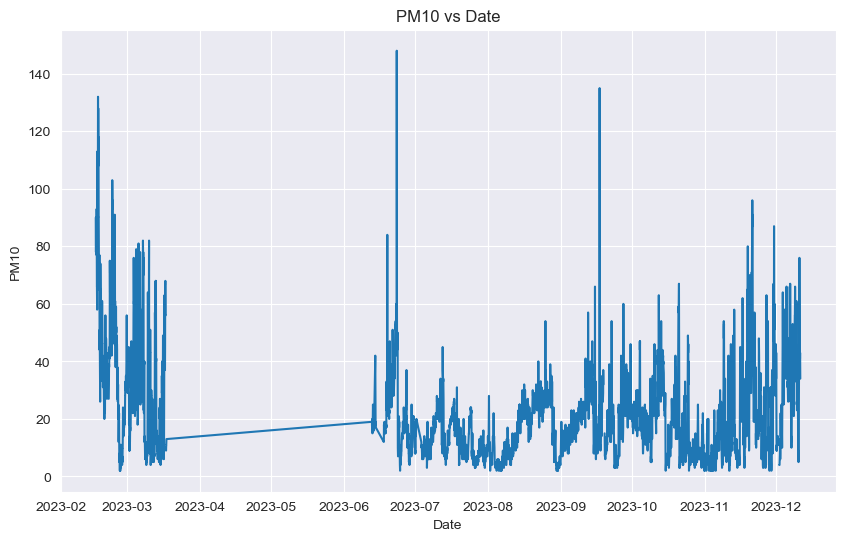

In [2219]:
plot_values('Date', 'PM10')

In [2220]:
# remove data before 2023-06
#df = df[df['Date'] >= '2023-06-01']
# DONT do this

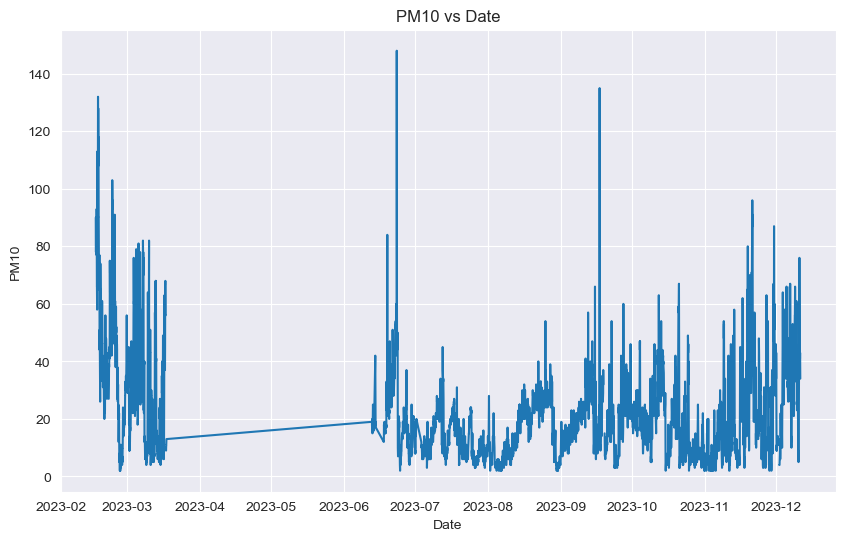

In [2221]:
plot_values('Date', 'PM10')

In [2222]:
# remove outliers 
# colud be a good idea
#df = df[df['PM10'] < 120]

In [2223]:
# MEH
# mean = df['PM10'].mean()
# std = df['PM10'].std()
# 
# z_score = (df['PM10'] - mean) / std
# threshold = 3
# 
# df = df[z_score < threshold]

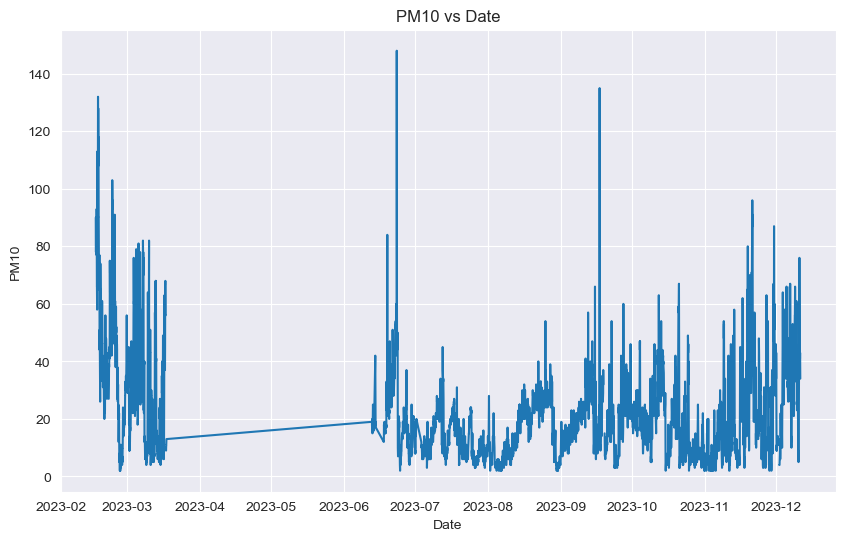

In [2224]:
plot_values('Date', 'PM10')

In [2225]:
df.head()

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10
42,2023-02-15 19:35:00+00:00,46.234818,15.267305,240.0,70.0,71.0,NaN,90.0
57,2023-02-15 20:15:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.0,86.0
55,2023-02-15 20:35:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.0,86.0
95,2023-02-15 21:15:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.0,78.0
88,2023-02-15 21:35:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.0,78.0


In [2226]:
df_weather = pd.read_csv('data/weather.csv')
df_weather.head()

,Date,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),surface_pressure (hPa),cloud_cover (%),wind_speed_10m (km/h),wind_direction_10m (°),soil_temperature_0_to_7cm (°C),soil_moisture_0_to_7cm (m³/m³),is_day ()
0,2023-01-01 00:15:00+00:00,7.7,85.0,5.3,5.5,0.0,0.0,0.0,992.7,7.0,6.7,144.0,2.6,0.357,0.0
1,2023-01-01 00:35:00+00:00,7.7,85.0,5.3,5.5,0.0,0.0,0.0,992.7,7.0,6.7,144.0,2.6,0.357,0.0
2,2023-01-01 01:15:00+00:00,7.8,84.0,5.2,5.7,0.0,0.0,0.0,992.8,4.0,6.4,133.0,2.1,0.356,0.0
3,2023-01-01 01:35:00+00:00,7.8,84.0,5.2,5.7,0.0,0.0,0.0,992.8,4.0,6.4,133.0,2.1,0.356,0.0
4,2023-01-01 02:15:00+00:00,4.8,92.0,3.6,1.9,0.0,0.0,0.0,992.5,10.0,9.2,141.0,1.8,0.356,0.0


In [2227]:
df_weather['Date'] = pd.to_datetime(df_weather['Date'], utc=True)

In [2228]:
df.isnull().sum()

Date           0
Latitude       0
Longitude      0
Altitude       0
NO2          402
PM2.5         67
O3           297
PM10          67
dtype: int64

In [2229]:
df = pd.merge(df, df_weather, on='Date', how='left')
df.head()

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10,temperature_2m (°C),relative_humidity_2m (%),...,precipitation (mm),rain (mm),snowfall (cm),surface_pressure (hPa),cloud_cover (%),wind_speed_10m (km/h),wind_direction_10m (°),soil_temperature_0_to_7cm (°C),soil_moisture_0_to_7cm (m³/m³),is_day ()
0,2023-02-15 19:35:00+00:00,46.234818,15.267305,240.0,70.0,71.0,NaN,90.0,0.5,91.0,...,0.0,0.0,0.0,996.8,0.0,8.0,190.0,0.4,0.348,0.0
1,2023-02-15 20:15:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.0,86.0,0.1,92.0,...,0.0,0.0,0.0,996.8,0.0,5.9,227.0,0.2,0.348,0.0
2,2023-02-15 20:35:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.0,86.0,0.1,92.0,...,0.0,0.0,0.0,996.8,0.0,5.9,227.0,0.2,0.348,0.0
3,2023-02-15 21:15:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.0,78.0,-1.1,93.0,...,0.0,0.0,0.0,996.6,0.0,4.6,252.0,0.1,0.348,0.0
4,2023-02-15 21:35:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.0,78.0,-1.1,93.0,...,0.0,0.0,0.0,996.6,0.0,4.6,252.0,0.1,0.348,0.0


In [2230]:
df["PM2.5/N02"] = df["PM2.5"] / df["NO2"]

df["PM2.5/03"] = df["PM2.5"] / df["O3"]

df['Season'] = df['Date'].dt.month.apply(lambda x: 'Winter' if (x == 12 or x <= 2) else
('Spring' if (3 <= x <= 5) else
 ('Summer' if (6 <= x <= 8) else
  ('Autumn' if (9 <= x <= 11) else None))))

df["Season"].astype('category')

df["Weekend"] = df["Date"].dt.dayofweek.apply(lambda x: 1 if (x == 5 or x == 6) else 0)

In [2231]:
df = pd.get_dummies(df, columns=['Season'])

In [2232]:
df.isnull().sum()

Date                                0
Latitude                            0
Longitude                           0
Altitude                            0
NO2                               402
PM2.5                              67
O3                                297
PM10                               67
temperature_2m (°C)                 1
relative_humidity_2m (%)            1
dew_point_2m (°C)                   1
apparent_temperature (°C)           1
precipitation (mm)                  1
rain (mm)                           1
snowfall (cm)                       1
surface_pressure (hPa)              1
cloud_cover (%)                     1
wind_speed_10m (km/h)               1
wind_direction_10m (°)              1
soil_temperature_0_to_7cm (°C)      1
soil_moisture_0_to_7cm (m³/m³)      1
is_day ()                           1
PM2.5/N02                         403
PM2.5/03                          297
Weekend                             0
Season_Autumn                       0
Season_Sprin

In [2233]:
# remove rows where PM10 is null
df = df[df['PM10'].notnull()]

In [2234]:
cols_to_fill = df.columns[df.isnull().any()].tolist()

In [2235]:
for col in cols_to_fill:
    incomplete_rows = df[df[col].isnull()]
    complete_rows = df[~df[col].isnull()]

    # Features and target columns excluding 'Date'
    features = [c for c in df.columns if c != col and c != 'Date']
    target = col

    X_train = complete_rows[features]
    y_train = complete_rows[target]

    model = HistGradientBoostingRegressor()

    model.fit(X_train, y_train)

    predicted_values = model.predict(incomplete_rows[features])

    df.loc[df[col].isnull(), col] = predicted_values

In [2236]:
df.isnull().sum()

Date                              0
Latitude                          0
Longitude                         0
Altitude                          0
NO2                               0
PM2.5                             0
O3                                0
PM10                              0
temperature_2m (°C)               0
relative_humidity_2m (%)          0
dew_point_2m (°C)                 0
apparent_temperature (°C)         0
precipitation (mm)                0
rain (mm)                         0
snowfall (cm)                     0
surface_pressure (hPa)            0
cloud_cover (%)                   0
wind_speed_10m (km/h)             0
wind_direction_10m (°)            0
soil_temperature_0_to_7cm (°C)    0
soil_moisture_0_to_7cm (m³/m³)    0
is_day ()                         0
PM2.5/N02                         0
PM2.5/03                          0
Weekend                           0
Season_Autumn                     0
Season_Spring                     0
Season_Summer               

In [2237]:
df.head()

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10,temperature_2m (°C),relative_humidity_2m (%),...,soil_temperature_0_to_7cm (°C),soil_moisture_0_to_7cm (m³/m³),is_day (),PM2.5/N02,PM2.5/03,Weekend,Season_Autumn,Season_Spring,Season_Summer,Season_Winter
0,2023-02-15 19:35:00+00:00,46.234818,15.267305,240.0,70.0,71.0,103.240981,90.0,0.5,91.0,...,0.4,0.348,0.0,1.014286,0.264237,0,False,False,False,True
1,2023-02-15 20:15:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.000000,86.0,0.1,92.0,...,0.2,0.348,0.0,1.357143,38.000000,0,False,False,False,True
2,2023-02-15 20:35:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.000000,86.0,0.1,92.0,...,0.2,0.348,0.0,1.357143,38.000000,0,False,False,False,True
3,2023-02-15 21:15:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.000000,78.0,-1.1,93.0,...,0.1,0.348,0.0,1.520833,36.500000,0,False,False,False,True
4,2023-02-15 21:35:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.000000,78.0,-1.1,93.0,...,0.1,0.348,0.0,1.520833,36.500000,0,False,False,False,True


In [2238]:
np.any(np.isnan(df))

False

In [2239]:
output_col = 'PM10'

input_cols = df.columns.tolist()
input_cols.remove(output_col)
input_cols.remove('Date')

information_gain_scores = mutual_info_regression(df[input_cols], df[output_col])

feature_importances = pd.Series(information_gain_scores, index=input_cols)
feature_importances.name = 'Information Gain Scores'
feature_importances.sort_values(ascending=False, inplace=True)

feature_importances.head(10)

PM2.5                             1.492543
PM2.5/03                          0.787464
PM2.5/N02                         0.549866
soil_moisture_0_to_7cm (m³/m³)    0.488029
dew_point_2m (°C)                 0.394603
soil_temperature_0_to_7cm (°C)    0.365422
NO2                               0.346245
apparent_temperature (°C)         0.331296
temperature_2m (°C)               0.314457
O3                                0.308833
Name: Information Gain Scores, dtype: float64

In [2240]:
top_features = feature_importances.head(3).index.tolist()
print(top_features)

['PM2.5', 'PM2.5/03', 'PM2.5/N02']


In [2241]:
def boxcox_transform(column):
    # create before and after plots for comparison
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.distplot(df[column], ax=ax[0])
    ax[0].set_title("Before Box-Cox")

    # transform data
    data = boxcox(df[column], lmbda=0.0)

    # create after plots
    sns.distplot(data, ax=ax[1])
    ax[1].set_title("After Box-Cox")

    # update dataframe
    df[column] = data

    plt.show()

In [2242]:
# for feature in top_features:
#     boxcox_transform(feature)

In [2243]:
target = "PM10"
features = [target] + top_features
dataset = df[features]

In [2244]:
dataset.shape

(5558, 4)

In [2245]:
test_split = round(len(dataset) * 0.3)

In [2246]:
train_data = dataset[:-test_split]
test_data = dataset[-test_split:]

In [2247]:
print(train_data.shape, test_data.shape)

(3891, 4) (1667, 4)


In [2248]:
scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [2249]:
def create_time_series(data, n_past):
    X, y = [], []
    for i in range(n_past, len(data)):
        X.append(data[i - n_past:i, 0:data.shape[1]])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [2250]:
# window_size = 48 * 7
# X_train, y_train = create_time_series(train_data, window_size)
# X_test, y_test = create_time_series(test_data, window_size)

In [2251]:
def create_multivariate_time_series(data, n_past, target_col=0, feature_cols=None):
    if feature_cols is None:
        feature_cols = list(range(data.shape[1]))

    X, y = [], []
    for i in range(n_past, len(data)):
        X.append(data[i - n_past:i, feature_cols])
        y.append(data[i, target_col])

    return np.array(X), np.array(y)

In [2252]:
# Usage of create_multivariate_time_series function
n_past = 10  # Number of past time steps to consider
target_col = 0  # Index of the target column (PM10) in your dataset
feature_cols = list(range(len(features)))  # All columns used as features

In [2253]:
# Creating input-output pairs using the function
X_train, y_train = create_multivariate_time_series(train_data, n_past, target_col, feature_cols)
X_test, y_test = create_multivariate_time_series(test_data, n_past, target_col, feature_cols)

In [2254]:
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[1])
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[1])

In [2255]:
print(f"Shape of training data: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape of testing data: X_test: {X_test.shape}, y_test: {y_test.shape}")

Shape of training data: X_train: (3881, 10, 4), y_train: (3881,)
Shape of testing data: X_test: (1657, 10, 4), y_test: (1657,)


In [2256]:
print(X_test.shape, y_test.shape)

(1657, 10, 4) (1657,)


In [2257]:
units = 64
optimizer = 'rmsprop'
dropout_rate = 0.4
activation = 'tanh'
batch_size = 128
epochs = 100

In [2258]:
def build_gru():
    model = Sequential(name="GRU")
    model.add(GRU(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(GRU(units=units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(GRU(units=units))
    model.add(Dense(units=32, activation=activation))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [2259]:
def build_conv_lstm():
    # Define the CNN-LSTM model
    model = Sequential()
    
    # Convolutional layers for feature extraction
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    # LSTM layers for sequence modeling
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50))
    
    # Output layer
    model.add(Dense(units=1))  # Adjust units for your specific output
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

In [2260]:
model = build_conv_lstm()

In [2261]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1,
                    shuffle=False)

Epoch 1/100
31/31 [==============================] - 3s 13ms/step - loss: 0.0288 - val_loss: 0.0076
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0099 - val_loss: 0.0081
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0090 - val_loss: 0.0079
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0061
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0054
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0048
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0040 - val_loss: 0.0046
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 11

In [2262]:
prediction = model.predict(X_test)

52/52 [==============================] - 0s 964us/step


In [2263]:
prediction.shape

(1657, 1)

In [2264]:
y_test.shape

(1657,)

In [2265]:
prediction_copies_array = np.repeat(prediction, dataset.shape[1], axis=-1)

In [2266]:
prediction_copies_array.shape

(1657, 4)

In [2267]:
pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(prediction), dataset.shape[1])))[:, 0]

In [2268]:
pred.shape

(1657,)

In [2269]:
pred

array([15.911343, 18.479937, 21.518776, ..., 51.457024, 51.857327,
       49.952778], dtype=float32)

In [2270]:
y_test_copies = np.repeat(y_test, dataset.shape[1], axis=-1)
y_test = scaler.inverse_transform(np.reshape(y_test_copies, (len(y_test), dataset.shape[1])))[:, 0]

In [2271]:
# mse,mea, evs
mse = mean_squared_error(y_test, prediction)
mae = mean_absolute_error(y_test, prediction)
evs = explained_variance_score(y_test, prediction)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Explained Variance Score: {evs}")

Mean Squared Error: 700.0795470674743
Mean Absolute Error: 21.14461412615894
Explained Variance Score: 0.01298885343493783


In [2272]:
dates = df['Date'].values

In [2273]:
df_output = pd.DataFrame({"Date":
                              dates[-test_split + n_past:], 'Actual': y_test, 'Predicted': pred})
df_output.head(1000)

,Date,Actual,Predicted
0,2023-10-02 19:35:00,19.0,15.911343
1,2023-10-02 20:35:00,20.0,18.479937
2,2023-10-02 21:35:00,28.0,21.518776
3,2023-10-02 22:35:00,30.0,27.219595
4,2023-10-02 23:35:00,26.0,37.284500
...,...,...,...
995,2023-11-13 09:35:00,44.0,57.165775
996,2023-11-13 10:35:00,36.0,55.081394
997,2023-11-13 11:35:00,24.0,64.348816
998,2023-11-13 12:35:00,14.0,40.230373


In [2274]:
def plot_results():
    plt.figure(figsize=(12, 8))
    plt.plot(df_output['Date'], df_output["Actual"], label='Actual')
    plt.plot(df_output['Date'], df_output['Predicted'], label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('PM10')
    plt.title('PM10 vs Time')
    plt.legend()
    plt.show()

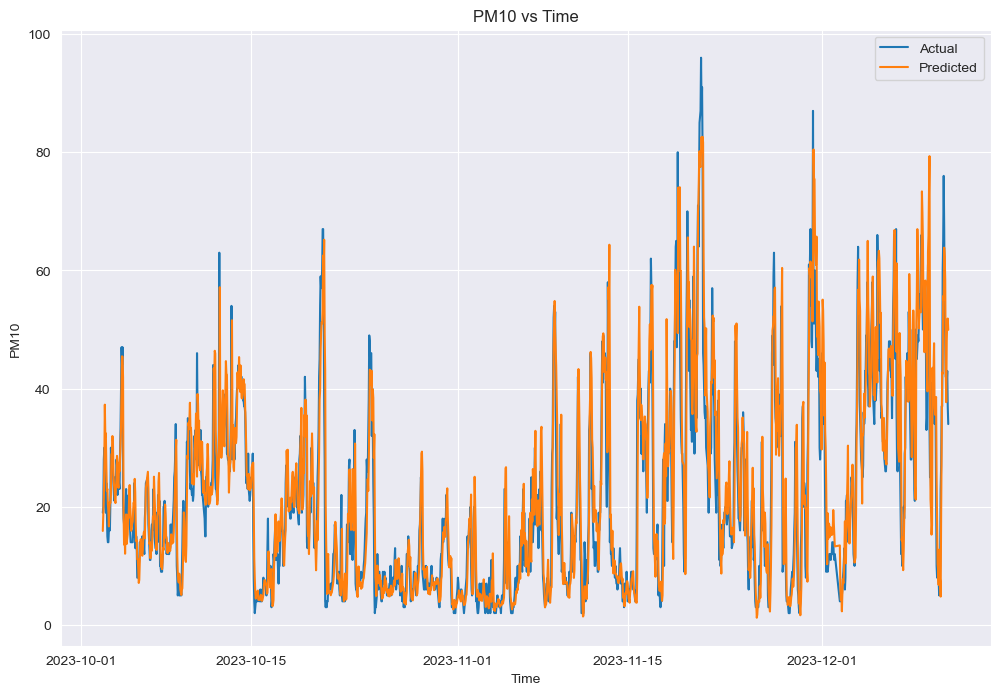

In [2275]:
plot_results()